# Klasifikasi Citra Sederhana

## 1. Mengimport Modul

In [1]:
import torch
import torchvision.models as models
import matplotlib.pyplot as plt
import tensorflow as tf
import os
from tensorflow import keras
from tensorflow.keras.preprocessing import image
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.layers import Input, Conv2D, MaxPooling2D, Flatten, Dense
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Adam

## Mengubah aktivasi CPU menjadi GPU

In [2]:
# buat tensor di CPU
x_cpu = torch.randn(5,5)

# Memindahkan tensor ke GPU
x_gpu = x_cpu.to('cuda')

AssertionError: Torch not compiled with CUDA enabled

### 2. Menginput Gambar dan Membuatnya dalam bentuk Dataset

In [4]:
# Contoh Penggunaan
image_dir = 'C:/Users/umalb/Dataset/dataset_kaggle_dedeikhsan/RiceLeafsDisease' #address folder gambar untuk dataset
original_image_size = (1600,1600) #input ukuran pada gambar asli
target_image_size = (224,224) # ukuran gambar yang diinginkan setelah diresize
batch_size = 32 # ukuran batch awal sebesar 32

# Mendapatkan path absolut dari direktori
current_directory = os.getcwd()
absolute_image_dir = os.path.join(current_directory, image_dir)

#Mengecek apakah direktori tersebut jalan atau tidak
if not os.path.exists(absolute_image_dir):
  raise FileNotFoundError(f"Direktori {absolute_image_dir} tidak ditemukan")


# Membuat Dataset Latihan (80% dari data total)
train_dataset = tf.keras.preprocessing.image_dataset_from_directory(
    directory = absolute_image_dir, #variabel pengarahan address dataset
    validation_split = 0.2, #20% data ini digunakan untuk validasi
    subset = 'training',
    seed = 123, #Random Seed untuk pergantian (shuffling)
    image_size = original_image_size, # untuk menspesifikasi ukuran gambar pd variabel image_size
    batch_size = batch_size)

# Membuat Dataset Validasi (20% dari data total)
val_dataset = tf.keras.preprocessing.image_dataset_from_directory(
    directory = absolute_image_dir,
    validation_split = 0.2, # 20% data tersebut untuk validasi
    subset = 'validation',
    seed = 123, # Random Seed untuk Pergantian (Data acak)
    image_size = original_image_size,
    batch_size = batch_size) # sebagai variabel input untuk mendapatkan nilai akurasi, loss, dll pada validasi

# Fungsi untuk meresize gambar
def resize_images(images, size):
  return tf.image.resize(images,size)

# Mendapatkan nama kelas sebelum dipetakan
class_names = train_dataset.class_names

# Resize gambar-gambar dalam dataset latihan
train_dataset = train_dataset.map(lambda x, y: (resize_images(x, target_image_size), y))

# Resize gambar-gambar dalam dataset validasi
val_dataset = val_dataset.map(lambda x, y: (resize_images(x, target_image_size), y))

# Print nama kelas setelah pemetaan
print(class_names)


Found 2628 files belonging to 2 classes.
Using 2103 files for training.
Found 2628 files belonging to 2 classes.
Using 525 files for validation.
['train', 'validation']


### 3. Menampilkan Dataset awal dari Sampel Acak sebanyak 20 Gambar

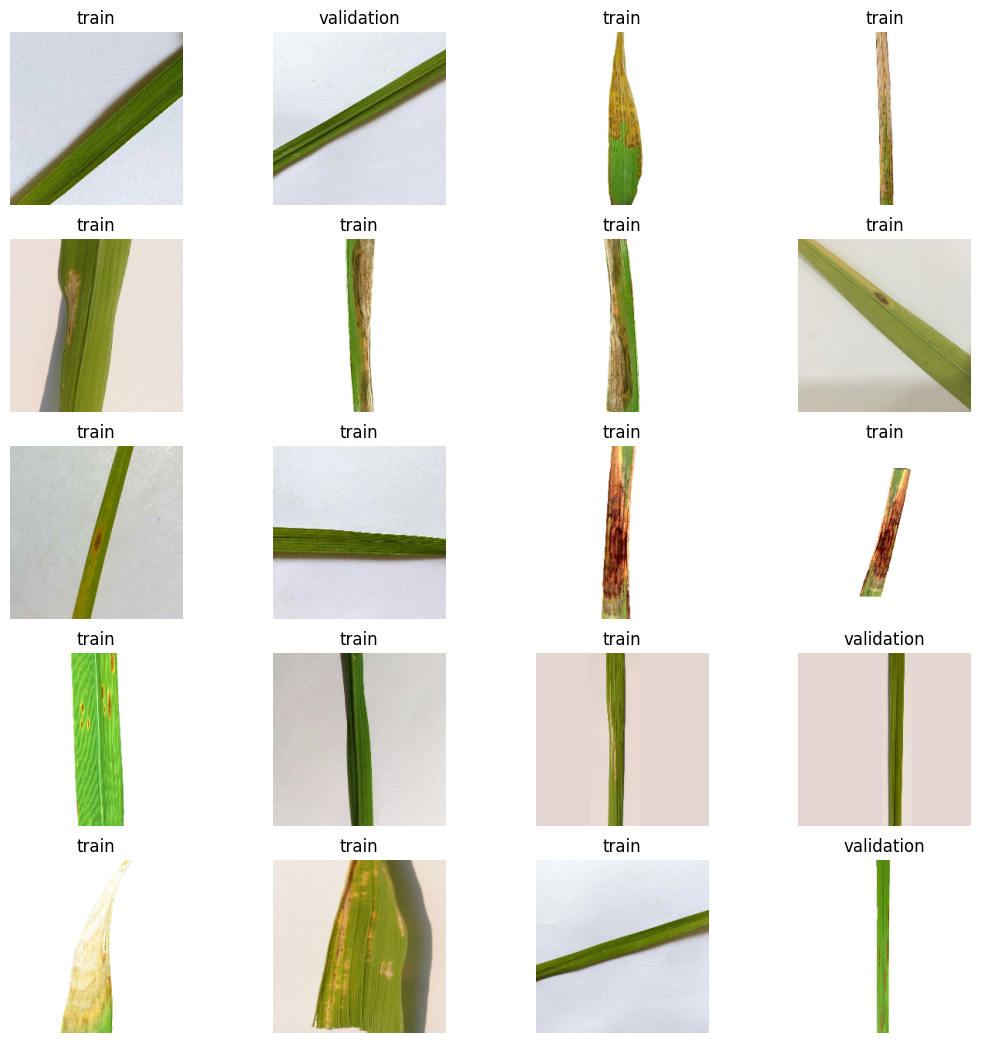

In [5]:
# Menampilkan 4x4 grid pada Gambar Latihan dari Dataset Tensorflow menggunakan tf.keras.utils.image_dataset_from_directory
figur = plt.figure(figsize = (13,13))
for images, labels in train_dataset.take(1):
    for i in range (20): #menampilkan 20 sampel random gambar latihan
        ax = plt.subplot(5,4, i+1)
        plt.imshow(images[i].numpy().astype('uint8'))
        plt.title(class_names[labels[i]])
        plt.axis('off')

In [ ]:
# Menampilkan 4x4 grid pada Gambar Validasi dari Dataset Tensorflow menggunakan tf.keras.utils.image_dataset_from_directory
figur = plt.figure(figsize = (13,13))
for images, labels in val_dataset.take(1):
    for i in range (20): #menampilkan 20 sampel random gambar latihan
        ax = plt.subplot(5,4, i+1)
        plt.imshow(images[i].numpy().astype('uint8'))
        plt.title(class_names[labels[i]])
        plt.axis('off')

## 4. Melakukan Ekstraksi Fitur Dataset

In [15]:
# Langkah 1 : Membuat Dataset Tensorflow dari Images Directory
def create_dataset(absolute_image_dir, target_image_size, batch_size):
    #Memuat dan memproses gambar dari Directory tersebut
    datagen = tf.keras.preprocessing.image.ImageDataGenerator(rescale = 1./255)
    # Menggunakan ImageDataGenerator untuk memuat dan memproses gambar dari direktori.
    # Rescale 1./255 digunakan untuk mengubah rentang piksel menjadi antara 0 dan 1.
    dataset = datagen.flow_from_directory(
        directory=absolute_image_dir,
        target_size = target_image_size, # ukuran target gambar yang diinginkan
        batch_size = batch_size, # ukuran batch data yang akan dimuat pada setiap iterasi
        class_mode = None, # Mode kelas. None berarti kita tidak membutuhkan label kelas karena kita menggunakan dataset ini untuk prediksi, bukan klasifikasi.
        shuffle = False) # shuffle=False berarti kita ingin menjaga urutan gambar sesuai dengan yang ada di direktori.
    
    return dataset

# Langkah 2 : mendefinisikan AlexNet Model untuk Ekstraksi Fitur
def create_alexnet_model(input_shape, num_classes):
    # Buat Input Layer
    input_layer = Input(shape = input_shape)

    #Inisiasi Fungsi Aktivasi ReLU
    fungsi_relu = tf.keras.layers.ReLU()
    
    #Conv Layer 1
    x = Conv2D(filters=96, kernel_size=(11,11), strides = (4,4), activation=fungsi_relu)(input_layer)
    x = MaxPooling2D(pool_size = (3,3), strides = (2,2))(x)
    
    #Conv Layer 2
    x = Conv2D(filters=256, kernel_size=(5,5), padding='same', activation=fungsi_relu)(x)
    x = MaxPooling2D(pool_size = (3,3), strides = (2,2))(x)
    
    #Conv Layer 3
    x = Conv2D(filters=384, kernel_size=(3,3), padding='same', activation=fungsi_relu)(x)
    
    #Conv Layer 4
    x = Conv2D(filters=384, kernel_size=(3,3), padding='same', activation=fungsi_relu)(x)
    
    #Conv Layer 5
    x = Conv2D(filters=256, kernel_size=(3,3), padding='same', activation=fungsi_relu)(x)
    x = MaxPooling2D(pool_size = (3,3), strides = (2,2))(x)
    
    #Flatten Layer
    x = Flatten()(x)
    
    #Fully Connected Layer 1
    x = Dense(4096, activation=fungsi_relu)(x)
    
    #Fully Connected Layer 2
    x = Dense(4096, activation=fungsi_relu)(x)
    
    #Output Layer
    
    ## Menjalankan lapisan Output pada Dense dari hasil Softmax
    output_layer = Dense(num_classes, activation='softmax')(x)
    
    #Buat Model dari input layer dan output layer
    model = tf.keras.Model(inputs=input_layer, outputs=output_layer)

    return model

# Langkah 3 : Mendeteksi Penyakit Daun Padi dan Menyediakan Bounding Boxes
def detect_and_bbox(dataset, model):
    predictions = model.predict(dataset, verbose =1)
    return predictions


### 5. Mendefinisikan AlexNet

In [16]:
input_shape = (*target_image_size, 3) #bentuk daripada input gambar
num_classes = len(class_names) # menentukan kelas dataset
# Buat model AlexNet
alexnet_model = create_alexnet_model(input_shape, num_classes=num_classes)
# menampilkan ringkasan model
alexnet_model.summary() #digunakan untuk memeriksa arsitektur yang kita buat

# Menjalankan Model dari CPU ke GPU
#models_cpu = models.alexnet_model()
#models_gpu = models_cpu.to('cuda')

Model: "functional_5"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer_2 (InputLayer)      │ (None, 224, 224, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_10 (Conv2D)              │ (None, 54, 54, 96)     │        34,944 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_6 (MaxPooling2D)  │ (None, 26, 26, 96)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_11 (Conv2D)              │ (None, 26, 26, 256)    │       614,656 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_7 (MaxPooling2D)  │ (None, 12, 12, 256)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_12 (Conv2D)              │ (None, 12, 12, 384)    │       885,120 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_13 (Conv2D)              │ (None, 12, 12, 384)    │     1,327,488 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_14 (Conv2D)              │ (None, 12, 12, 256)    │       884,992 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_8 (MaxPooling2D)  │ (None, 5, 5, 256)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_2 (Flatten)             │ (None, 6400)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_6 (Dense)                 │ (None, 4096)           │    26,218,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_7 (Dense)                 │ (None, 4096)           │    16,781,312 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_8 (Dense)                 │ (None, 2)              │         8,194 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 46,755,202 (178.36 MB)

 Trainable params: 46,755,202 (178.36 MB)

 Non-trainable params: 0 (0.00 B)

AttributeError: module 'torchvision.models' has no attribute 'alexnet_model'

### 6. Mengcompile AlexNet dengan Pendekatan Aturan untuk TL

In [ ]:
# Menyusun Model AlexNet dengan Pendekatan untuk Transfer Learning
alexnet_model.compile(optimizer = 'adam',
                      loss = tf.keras.losses.SparseCategoricalCrossentropy(from_logits=False),
                     metrics = ['accuracy']) # Loss = 'mean_squared_error', metrics = ['mse']

num_epochs = 20
# Melatih model tersebut dan mendapatkan jejak latihan
# alexnet_model.fit(train_dataset, epoch=num_epochs, validation_data = val_dataset)
history = alexnet_model.fit(train_dataset, epochs=num_epochs, validation_data=val_dataset)

## 7. Membuat Plot untuk Loss pada Latihan dan Validasi

In [ ]:
# Membuat Plot Latihan Vs Plot Validasi

plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label = 'Validation Loss')
plt.title('Training and Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.show()

plt.plot(history.history['accuracy'], label='Training Data Accuracy')
plt.plot(history.history['val_loss'], label = 'Validation Data Accuracy')
plt.title('Training and Validation Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()
plt.show()


In [ ]:
# Menampilkan nilai akurasi dan loss pada nilai set validasi
loss, accuracy = alexnet_model.evaluate(val_dataset)
print(f"Validation Loss {loss}")
print(f"Validation Accuracy {accuracy}")

### 8. Mendeteksi Penyakit Daun Padi dan Menyediakan Kotak Pembatas

In [ ]:
# Mendeteksi dan membuat Kotak Pembatas
predictions = detect_and_bbox(val_dataset, alexnet_model)

### 9. Menampilkan Konfusi Matriks Data Latihan

In [ ]:
# Menampilkan Confusi Matriks dalam Data Latihan

import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import tensorflow as tf
from sklearn.metrics import confusion_matrix

#Contoh Penggunaan
num_runs = 5 # Bilangan running rerata sampai lebih dari -n
dataset = train_dataset # dataset tensorflow
# model = tf.keras.models.load_model('model_class_13_balances_combined_ep_50.h5')  # Your trained TensorFlow model

def compute_confusion_matrix(alexnet_model, dataset, num_runs):
    all_true_labels = []
    all_pred_labels = []

    for _ in range(num_runs):
        true_labels = []
        pred_labels = []

        # Membuat Prediksi dalam dataset
        for features, labels in dataset:
            predictions = alexnet_model.predict(features)
            true_labels.extend(labels.numpy())
            pred_labels.extend(np.argmax(predictions, axis = 1))

        all_true_labels.append(true_labels)
        all_pred_labels.append(pred_labels)

    #Mengkomputasi Confusi Matrix untuk tiap Running
    all_conf_matrices = [confusion_matrix(true_labels, pred_labels) for true_labels, pred_labels in zip(all_true_labels, all_pred_labels)]

    # rerata Confusi Matrix
    avg_conf_matrix = np.mean(all_conf_matrices, axis=0)

    return avg_conf_matrix

avg_conf_matrix = compute_confusion_matrix(alexnet_model, dataset, num_runs)
print(f"Average Confusion Matrix : \n\n {avg_conf_matrix}")

# Mengubah Confusi Matrix menjadi Integers
avg_conf_matrix = avg_conf_matrix.astype(int)

class_names = class_names



### 10. Membuat HeatMap Data Training

In [ ]:
# Membuat Plot Heat Map

plt.figure(figsize = (10,8))
sns.heatmap(avg_conf_matrix, annot=True, fmt='d', cmap = 'Greens', cbar = True,
           xticklabels=class_names, yticklabels=class_names)
plt.xlabel('Predicted Labels')
plt.ylabel('True Labels')
plt.title('Confusion Matrix')
plt.show()

### 11. Menampilkan Konfusi Matriks pada Data Validasi

In [ ]:
# Menampilkan Confusi Matriks dalam Data Latihan

import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import tensorflow as tf
from sklearn.metrics import confusion_matrix

#Contoh Penggunaan
num_runs = 5 # Bilangan running rerata sampai lebih dari -n
dataset = val_dataset # dataset tensorflow
# model = tf.keras.models.load_model('model_class_13_balances_combined_ep_50.h5')  # Your trained TensorFlow model

def compute_confusion_matrix(alexnet_model, dataset, num_runs):
    all_true_labels = []
    all_pred_labels = []

    for _ in range(num_runs):
        true_labels = []
        pred_labels = []

        # Membuat Prediksi dalam dataset
        for features, labels in dataset:
            predictions = alexnet_model.predict(features)
            true_labels.extend(labels.numpy())
            pred_labels.extend(np.argmax(predictions, axis = 1))

        all_true_labels.append(true_labels)
        all_pred_labels.append(pred_labels)

    #Mengkomputasi Confusi Matrix untuk tiap Running
    all_conf_matrices = [confusion_matrix(true_labels, pred_labels) for true_labels, pred_labels in zip(all_true_labels, all_pred_labels)]

    # rerata Confusi Matrix
    avg_conf_matrix = np.mean(all_conf_matrices, axis=0)

    return avg_conf_matrix

avg_conf_matrix = compute_confusion_matrix(alexnet_model, dataset, num_runs)
print(f"Average Confusion Matrix : \n\n {avg_conf_matrix}")

# Mengubah Confusi Matrix menjadi Integers
avg_conf_matrix = avg_conf_matrix.astype(int)

class_names = class_names



### 12. Membuat HeatMap Data Validasi

In [ ]:
# Membuat Plot Heat Map

plt.figure(figsize = (10,8))
sns.heatmap(avg_conf_matrix, annot=True, fmt='d', cmap = 'Greens', cbar = True,
           xticklabels=class_names, yticklabels=class_names)
plt.xlabel('Predicted Labels')
plt.ylabel('True Labels')
plt.title('Confusion Matrix')
plt.show()

## 13. Menampilkan Laporan Klasifikasi Data Training dan Validasi

In [ ]:
import numpy as np
import tensorflow as tf
from sklearn.metrics import classification_report
import pandas as pd

# Contoh Penggunaan
num_runs = 5
dataset = train_dataset


def compute_classification_report(model, dataset):
    true_labels = []
    pred_labels = []

    # membuat prediksi pada dataset
    for features, labels in dataset:
        predictions = alexnet_model.predict(features)
        true_labels.extend(labels.numpy())
        pred_labels.extend(np.argmax(predictions, axis=1))

    # Mengkomputasikan laporan Klasifikasi
    classification_report_str = classification_report(true_labels, pred_labels)
    return classification_report_str


# Mengkomputasi Hasil Laporan Klasifikasi
classification_report_result = compute_classification_report(alexnet_model, dataset)

# Menampilkan Laporan Klasifikasi
print(f"Classification Report :\n\n {classification_report_result}")


In [ ]:
import numpy as np
import tensorflow as tf
from sklearn.metrics import classification_report
import pandas as pd

# Contoh Penggunaan
num_runs = 5
dataset = val_dataset


def compute_classification_report(model, dataset):
    true_labels = []
    pred_labels = []

    # membuat prediksi pada dataset
    for features, labels in dataset:
        predictions = alexnet_model.predict(features)
        true_labels.extend(labels.numpy())
        pred_labels.extend(np.argmax(predictions, axis=1))

    # Mengkomputasikan laporan Klasifikasi
    classification_report_str = classification_report(true_labels, pred_labels)
    return classification_report_str


# Mengkomputasi Hasil Laporan Klasifikasi
classification_report_result = compute_classification_report(alexnet_model, dataset)

# Menampilkan Laporan Klasifikasi
print(f"Classification Report :\n\n {classification_report_result}")
